# Assignment 4 - Mythili K

## 1. Importing libraries

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Tokenization libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
# Reading the dataset
df = pd.read_csv("spam.csv",delimiter = ',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.columns


Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [4]:
# Deleting unwanted columns and renaming the colunmns
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df = df.rename(
{
    'v1':'Label',
    'v2':'Message'
},
    axis=1
)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
# Checking for null values
df.isnull().sum()

Label      0
Message    0
dtype: int64

In [7]:
# Creating Message length as new column
df["Message Length"] = df["Message"].apply(len)

In [8]:
df.head()

,Label,Message,Message Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## 2.Message length visualization 

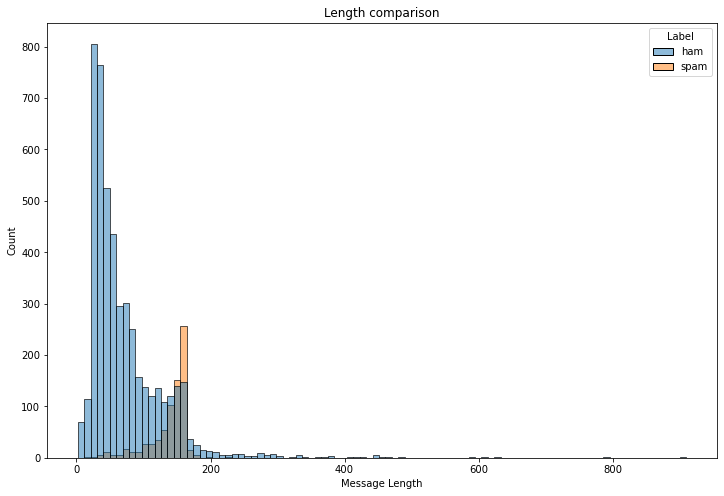

In [9]:
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=df["Message Length"],
    hue=df["Label"]
)
plt.title("Length comparison")
plt.show()

## 3.Message Description

In [10]:
#Ham message description
ham_len = df[df['Label']=="ham"]["Message Length"].describe()
print("Description of ham messages:")
print(ham_len)
print()
#Spam message description
spam_len = df[df['Label']=="spam"]["Message Length"].describe()
print("Description of ham messages:")
print(spam_len)

Description of ham messages:
count    4825.000000
mean       71.023627
std        58.016023
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: Message Length, dtype: float64

Description of ham messages:
count    747.000000
mean     138.866131
std       29.183082
min       13.000000
25%      132.500000
50%      149.000000
75%      157.000000
max      224.000000
Name: Message Length, dtype: float64


In [11]:
df.describe()

,Message Length
count,5572.000000
mean,80.118808
std,59.690841
min,2.000000
25%,36.000000
50%,61.000000
75%,121.000000
max,910.000000


In [12]:
# Two unique values
df['Label'].value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

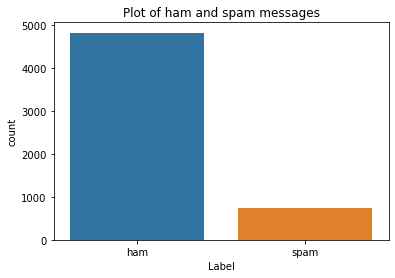

In [13]:
# Visualization of labels
sns.countplot(data=df,x='Label')
plt.title('Plot of ham and spam messages')
plt.show()

### The dataset is imbalanced with more than 85% of ham message and 15% of spam message

## 4.Undersampling

In [14]:
# Length computation
maj_len = len(df[df['Label']=='ham'])
min_len = len(df[df['Label']=='spam'])

#Storing of indices
maj_index = df[df['Label'] == 'ham'].index
min_index = df[df['Label'] == 'spam'].index

#new index
new_index = np.random.choice(maj_index,size=min_len,replace=False)

In [15]:
# Concatenate two indices
df1 = np.concatenate([min_index,new_index])

In [16]:
#new Dataframe
df1 = df.loc[df1]

In [17]:
# Shuffling the sample
df1=df1.sample(frac=1)
df1=df1.reset_index()
df1 = df1.drop(
    columns=['index']
)
#shape 
df1.shape

(1494, 3)

In [18]:
df1['Label'].value_counts()

spam    747
ham     747
Name: Label, dtype: int64

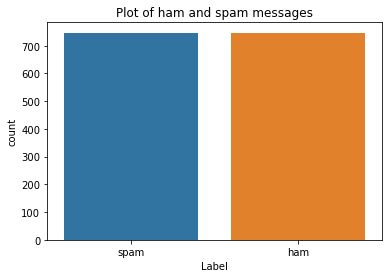

In [19]:
# Visualization of labels after undersampling
sns.countplot(data=df1,x='Label')
plt.title('Plot of ham and spam messages')
plt.show()

In [20]:
#Encoding ham and spam
df1['Value'] = df1['Label'].map(
{
    "ham" : 0,
    "spam" : 1
}
)
df1.head()

,Label,Message,Message Length,Value
0,spam,You have won a guaranteed å£200 award or even ...,143,1
1,spam,You have been selected to stay in 1 of 250 top...,147,1
2,ham,\Keep ur problems in ur heart,29,0
3,spam,WIN a year supply of CDs 4 a store of ur choic...,147,1
4,spam,FreeMsg: Fancy a flirt? Reply DATE now & join ...,156,1


In [21]:
stemmer = PorterStemmer()
corpus = []
for msg in df1["Message"]:
    msg = re.sub('[^a-zA-Z]'," ",msg)
    msg = msg.lower()
    msg = msg.split()
    msg = [stemmer.stem(words)
           for words in msg
           if words not in set(stopwords.words("english"))
          ]
    msg = " ".join(msg)
    corpus.append(msg)

In [22]:
vocab = 10000
onehot_doc = [one_hot(words,n=vocab)
             for words in corpus]

In [23]:
df1["Message Length"].describe()

count    1494.000000
mean      105.265730
std        56.849913
min         3.000000
25%        50.250000
50%       120.000000
75%       153.000000
max       588.000000
Name: Message Length, dtype: float64

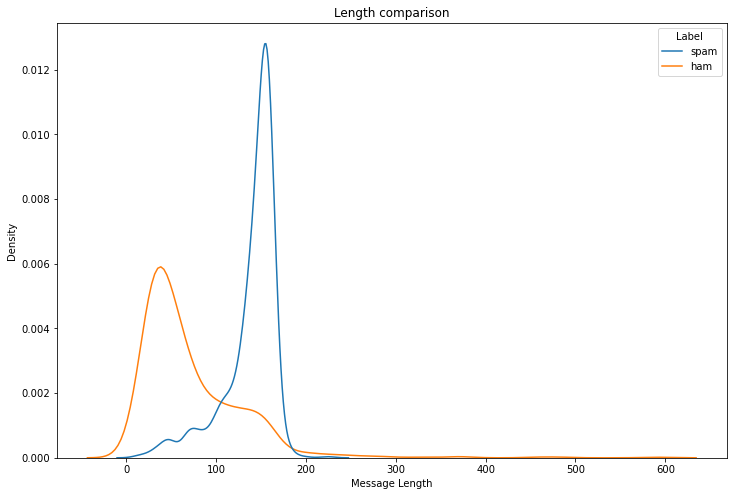

In [24]:
fig=plt.figure(figsize=(12,8))
sns.kdeplot(
    x = df1['Message Length'],
    hue = df1['Label']
)
plt.title("Length comparison")
plt.show()

In [25]:
# word embedding
sen_len = 200
embed = pad_sequences(onehot_doc,maxlen=sen_len,padding="pre")

In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Label           1494 non-null   object
 1   Message         1494 non-null   object
 2   Message Length  1494 non-null   int64 
 3   Value           1494 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.8+ KB


In [27]:
# Creating dataframe
new_dataframe = pd.DataFrame(data = embed)
target=df1["Value"]

In [28]:
# Dataframe concatenation
df_final = pd.concat([new_dataframe,target],axis=1)

In [29]:
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Value
0,0,0,0,0,0,0,0,0,0,0,...,9399,5142,5213,2808,4862,8633,8127,4708,2307,1
1,0,0,0,0,0,0,0,0,0,0,...,3451,910,5654,890,5213,8663,6573,8858,4832,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2824,9399,5131,9399,2003,0
3,0,0,0,0,0,0,0,0,0,0,...,188,4911,7336,3396,606,5367,2381,6178,5347,1
4,0,0,0,0,0,0,0,0,0,0,...,4925,746,693,9347,2454,237,4862,9698,9794,1


In [30]:
# Splitting dataframe
x = df_final.drop("Value",axis=1)
y = df_final["Value"]

In [31]:
# Train test split
xtrainval,xtest,ytrainval,ytest=train_test_split(x,y,random_state=42,test_size=0.15)

In [32]:
xtrain,xval,ytrain,yval=train_test_split(xtrainval,ytrainval,random_state=42,test_size=0.15)

## 5.Model building

In [33]:
model = Sequential()

In [34]:
feature_num = 100
model.add(Embedding(input_dim=vocab,output_dim=feature_num,input_length=sen_len))
model.add(LSTM(units=128,activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
#Layer2
model.add(LSTM(units=60, activation = 'relu'))
model.add(Dropout(0.3))
#output layer
model.add(Dense(units=1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 200, 128)          117248    
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 60)                45360     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 1,162,669
Trainable params: 1,162,669
Non-

In [35]:
# Compilation of model
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=["accuracy"])

## 6.Model Training

In [36]:
# Model fit
model.fit(xtrain,ytrain,validation_data=(xval,yval),epochs=50)

Epoch 1/50
34/34 [==============================] - 20s 483ms/step - loss: nan - accuracy: 0.5473 - val_loss: nan - val_accuracy: 0.4503
Epoch 2/50
34/34 [==============================] - 15s 427ms/step - loss: nan - accuracy: 0.5009 - val_loss: nan - val_accuracy: 0.4503
Epoch 3/50
34/34 [==============================] - 15s 425ms/step - loss: nan - accuracy: 0.5009 - val_loss: nan - val_accuracy: 0.4503
Epoch 4/50
34/34 [==============================] - 19s 552ms/step - loss: nan - accuracy: 0.5009 - val_loss: nan - val_accuracy: 0.4503
Epoch 5/50
34/34 [==============================] - 22s 635ms/step - loss: nan - accuracy: 0.5009 - val_loss: nan - val_accuracy: 0.4503
Epoch 6/50
34/34 [==============================] - 19s 554ms/step - loss: nan - accuracy: 0.5009 - val_loss: nan - val_accuracy: 0.4503
Epoch 7/50
34/34 [==============================] - 15s 447ms/step - loss: nan - accuracy: 0.5009 - val_loss: nan - val_accuracy: 0.4503
Epoch 8/50
34/34 [=======================

In [37]:
# prediction
y_pred = model.predict(xtest)
y_pred = (y_pred>0.5)

In [38]:
# Model accuracy score
score=accuracy_score(ytest,y_pred)
print("Test Score:{:.2f}%".format(score*100))

Test Score:53.78%


## 7.Model Evaluation

In [39]:
model.evaluate(xtest,ytest)

8/8 [==============================] - 1s 130ms/step - loss: nan - accuracy: 0.5378


[nan, 0.5377777814865112]

In [40]:
def cls_message(model,msg):
    msg = re.sub('[^a-zA-Z]'," ",msg)
    msg = msg.lower()
    msg = msg.split()
    msg = [stemmer.stem(words)
           for words in msg
           if words not in set(stopwords.words("english"))
          ]
    msg = " ".join(msg)
    oneHot=[one_hot(msg,n=vocab)]
    text=pad_sequences(oneHot,maxlen=sen_len,padding="pre")
    predict=model.predict(text)
    if predict>0.5:
        print("It is a spam")   
    else:
        print("It is not a spam")

## 8.Testing

In [41]:
#message
msg1 = "Your gonna have to pick up a $1 burger for yourself on your way home. I can't even move. Pain is killing me."
msg2 = "Hurray!! You won a cash prize of 3000rs."

In [42]:
cls_message(model,msg1)

It is not a spam


In [43]:
cls_message(model,msg2)


It is not a spam
